# Setup

In [6]:
from scipy.optimize import curve_fit
import numpy as np
from scipy.stats import anderson
from scipy.stats import kstest
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams.update({
    "font.size": 16,        # Base font size
    "axes.titlesize": 18,   # Title font size
    "axes.labelsize": 16,   # Axis label size
    "xtick.labelsize": 14,  # X tick labels
    "ytick.labelsize": 14,  # Y tick labels
    "legend.fontsize": 10,  # Legend font
    "figure.titlesize": 20  # Figure title
})

In [7]:
np.random.seed(42)

mu, sigma = 0,1

n= 1000

dist1 = np.random.normal(mu,sigma,n)
dist2 = np.random.normal(mu,sigma,n)

# Propagator

[-2.   -1.98 -1.96 -1.94 -1.92 -1.9  -1.88 -1.86 -1.84 -1.82 -1.8  -1.78
 -1.76 -1.74 -1.72 -1.7  -1.68 -1.66 -1.64 -1.62 -1.6  -1.58 -1.56 -1.54
 -1.52 -1.5  -1.48 -1.46 -1.44 -1.42 -1.4  -1.38 -1.36 -1.34 -1.32 -1.3
 -1.28 -1.26 -1.24 -1.22 -1.2  -1.18 -1.16 -1.14 -1.12 -1.1  -1.08 -1.06
 -1.04 -1.02 -1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82
 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58
 -0.56 -0.54 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34
 -0.32 -0.3  -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1
 -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14
  0.16  0.18  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38
  0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86
  0.88  0.9   0.92  0.94  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1
  1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.26  1.28

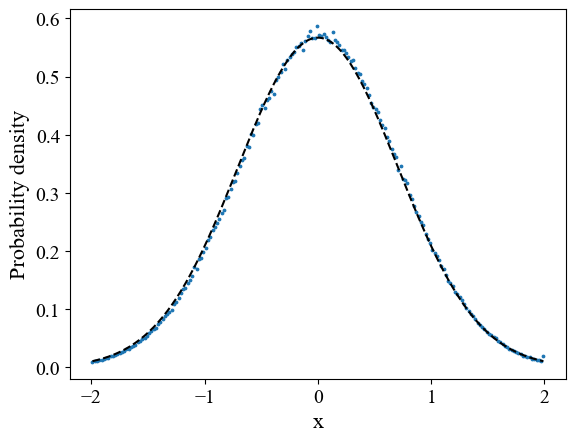

201000


In [8]:
# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 150  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]


# Potential
def x_potential(x):
    return 1 / 2 * x ** 2


def y_potential(x):
    return 1000 * x ** 4


def ho_analytic_pdf(x):
    return (1 / np.sqrt(np.pi)) * np.exp(-x ** 2)


def residual_calculator1(x_values, model, model_parameters, y_values, y_errors):
    theoretical_values = model(x_values, *model_parameters)
    residuals = (y_values - theoretical_values) / y_errors
    return residuals


def residual_calculator2(theoretical_values, y_values, y_errors):
    residuals = (y_values - theoretical_values) / y_errors
    return residuals


# Propagator Data
# Setting Constants

#position boundaries
x_0_prop = 0
x_endpoints_prop = np.linspace(-2, 2, 201)

#time boundaries
t_i_prop = 0
t_f_prop = 6

#other constants
mass_prop = 1
steps_prop = 7
numb_paths_prop = 1000

#array of times
times_prop = np.linspace(t_i_prop, t_f_prop, steps_prop)
dt_prop = times_prop[1] - times_prop[0]
print(x_endpoints_prop)


#Creating the position generating function

def Pos_Gen_prop(x0, xN, Steps, noise_scale=0.3):  #Generates smooth paths with noise
    xs = np.linspace(x0, xN, Steps)
    noise = np.random.normal(0, noise_scale, size=Steps)
    noise[0] = 0.0
    noise[-1] = 0.0
    return xs + noise


#Creating function to evaluate the action integral for a path

def action_harmonic_prop(positions, times, mass):
    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times) - 1):
        dt = times[i + 1] - times[i]
        dx = positions[i + 1] - positions[i]
        T = 0.5 * mass * (dx / dt) ** 2
        V = 0.5 * (((positions[i] + positions[i + 1]) / 2) ** 2)
        S += dt * (T + V)

    return S


# Generating Paths and calculating weight of each path
paths_prop = []
weights_prop = []
x_end_prop = []

for xN in x_endpoints_prop:
    for _ in range(numb_paths_prop):
        p = Pos_Gen_prop(x_0_prop, xN, steps_prop)
        S = action_harmonic_prop(p, times_prop, mass_prop)
        w = np.exp(-S)
        paths_prop.append(p)
        weights_prop.append(w)
        x_end_prop.append(xN)

paths_prop = np.array(paths_prop)
weights_prop = np.array(weights_prop)
x_end_prop = np.array(x_end_prop)

print(paths_prop[0])
print(len(paths_prop))
print(paths_prop[999:1001])

# Finding the groundstate wave function of the path
x_bins_prop = np.linspace(-2, 2, 201)

pdf_unnormalised_prop, bin_edges_prop = np.histogram(x_end_prop, bins=x_bins_prop, weights=weights_prop)
x_centres_prop = 0.5 * (bin_edges_prop[1:] + bin_edges_prop[:-1])
dx_prop = np.diff(x_bins_prop)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area_prop = np.sum(pdf_unnormalised_prop * dx_prop)
pdf_prop = pdf_unnormalised_prop / (area_prop)

# --- Analytic PDF for comparison (half side only) ---
phi_sq_analytic_prop = (1 / np.sqrt(np.pi)) * np.exp(-x_centres_prop ** 2)
phi_sq_analytic_prop /= np.sum(phi_sq_analytic_prop * dx_prop)  # normalize area to 0.5

# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf_prop * dx_prop):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_prop * dx_prop):.5f}")

plt.figure(1)
plt.scatter(x_centres_prop, pdf_prop, label='Path integral estimate', s=3)
plt.plot(x_centres_prop, phi_sq_analytic_prop, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.show()

print(len(x_end_prop))

# Q-Q Plot

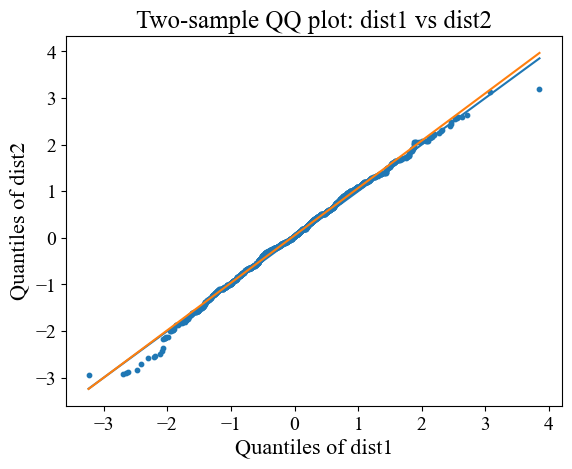

In [9]:
import matplotlib.pyplot as plt

# Sort the data
dist1_sorted = np.sort(dist1)
dist2_sorted = np.sort(dist2)
a, b = np.polyfit(dist1_sorted, dist2_sorted, 1)

# Make QQ plot
plt.figure()
plt.scatter(dist1_sorted, dist2_sorted, s=10)

# Reference line y = x
min_val = min(dist1_sorted.min(), dist2_sorted.min())
max_val = max(dist1_sorted.max(), dist2_sorted.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.plot(dist1_sorted, a * dist1_sorted + b)

plt.xlabel("Quantiles of dist1")
plt.ylabel("Quantiles of dist2")
plt.title("Two-sample QQ plot: dist1 vs dist2")
plt.show()

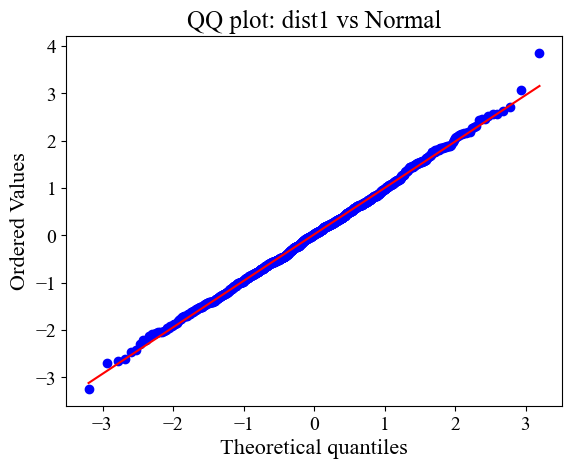

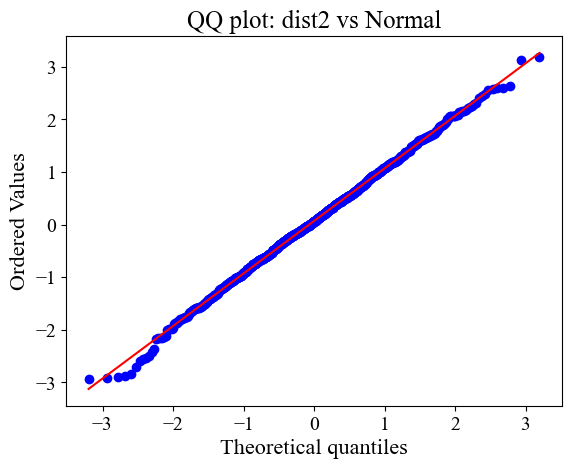

In [10]:
import scipy.stats as stats

stats.probplot(dist1, dist="norm", plot=plt)
plt.title("QQ plot: dist1 vs Normal")
plt.show()

stats.probplot(dist2, dist="norm", plot=plt)
plt.title("QQ plot: dist2 vs Normal")
plt.show()


# Correct Q-Q Plot formatting

In [11]:
import matplotlib as mpl
import scipy.stats as stats

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

In [12]:
cmap_color = "cool"

# --- Compute QQ data ---
(osm, osr), (slope, intercept, r) = stats.probplot(dist1, dist="norm")
n = len(osr)

# Pointwise negative log-likelihood under theoretical PDF
# (HO ground state ~ Gaussian with known sigma)
sigma = 1.0  # <-- set this to your theoretical value
nll = -stats.norm.logpdf(osr, loc=0, scale=sigma)

# Plotting positions
p = (np.arange(1, n + 1) - 0.5) / n

# Normal PDF at theoretical quantiles
pdf = stats.norm.pdf(osm)

# Standard error of quantiles
sigma_q = np.sqrt(p * (1 - p)) / (np.sqrt(n) * pdf)

# 95% confidence envelope
z_alpha = 1.96
upper = osm + z_alpha * sigma_q
lower = osm - z_alpha * sigma_q

# Detrended residuals
qq_res = osr - osm

sizes = 20 + 20 * (np.abs(qq_res) / np.max(np.abs(qq_res)))

from matplotlib import colors

vmin = np.percentile(nll, 5)
vmax = np.percentile(nll, 95)

norm = colors.Normalize(vmin=vmin, vmax=vmax)


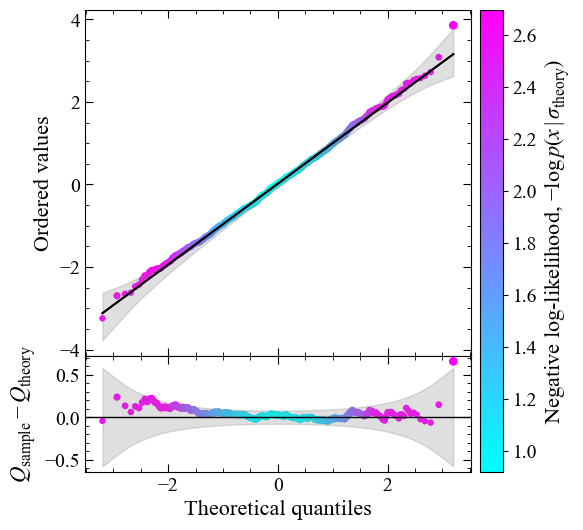

In [13]:
# --- Figure layout ---
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)

ax_qq = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax_qq)

# -------------------
# Top: QQ plot
# -------------------
sc = ax_qq.scatter(
    osm, osr,
    c=nll,
    norm = norm,
    cmap= cmap_color,
    s=sizes,
    edgecolors='none'
)

ax_qq.plot(
    osm,
    slope * osm + intercept,
    color='black',
    lw=1.2,
    alpha=0.8
)


ax_qq.plot(osm, slope * osm + intercept, color='black', lw=1.5)
ax_qq.fill_between(osm, lower, upper, color='grey', alpha=0.25)

ax_qq.set_ylabel("Ordered values")
ax_qq.minorticks_on()
ax_qq.tick_params(which='major', length=6, direction='in', top=True, right=True)
ax_qq.tick_params(which='minor', length=3, direction='in', top=True, right=True)

plt.setp(ax_qq.get_xticklabels(), visible=False)

# -------------------
# Bottom: detrended QQ
# -------------------
ax_res.scatter(
    osm, qq_res,
    c=nll,
    norm = norm,
    cmap= cmap_color,
    s=sizes,
    edgecolors='none'
)


# ±2σ band
ax_res.axhline(0, color='black', lw=1)

ax_res.set_xlabel("Theoretical quantiles")
ax_res.set_ylabel(r"$Q_{\mathrm{sample}} - Q_{\mathrm{theory}}$")

ax_res.minorticks_on()
ax_res.tick_params(which='major', length=6, direction='in', top=True, right=True)
ax_res.tick_params(which='minor', length=3, direction='in', top=True, right=True)

res_upper =  z_alpha * sigma_q
res_lower = -z_alpha * sigma_q

ax_res.fill_between(
    osm,
    res_lower,
    res_upper,
    color='grey',
    alpha=0.25
)


# -------------------
# Colorbar (|z|)
# -------------------
cbar = fig.colorbar(sc, ax=[ax_qq, ax_res], pad=0.02)
cbar.set_label(
    r"Negative log-likelihood, $-\log p(x\,|\,\sigma_{\mathrm{theory}})$"
)


plt.show()


In [14]:
stats.norm.cdf(7)  # ~1 - 1e-12  → massive AD penalty
stats.norm.cdf(2)  # ~0.977     → modest


np.float64(0.9772498680518208)

# Q-Q For Propagator

In [21]:
N_samples = 10000
N_repeats = 100

weights = weights_prop/np.sum(weights_prop)

sample_matrix = np.empty((N_repeats, N_samples))



for i in range(N_repeats):
    sample_matrix[i] = np.random.choice(
        x_end_prop,
        size=N_samples,
        p=weights
    )

# Sort each subsample
ordered_samples = np.sort(sample_matrix, axis=1)

# Average order statistics
samples_prop = np.mean(ordered_samples, axis=0)

print(len(samples_prop))

laptop_savepath_qq_prop = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\qq_prop.svg"
pc_savepath_qq_prop = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\qq_prop.svg"

10000


In [22]:
cmap_color = "cool"

# --- Compute QQ data ---
(osm, osr), (slope, intercept, r) = stats.probplot(samples_prop, dist="norm")
n = len(osr)

# Pointwise negative log-likelihood under theoretical PDF
# (HO ground state ~ Gaussian with known sigma)
sigma = 1/np.sqrt(2)  # <-- set this to your theoretical value
nll = -stats.norm.logpdf(osr, loc=0, scale=sigma)

# Plotting positions
p = (np.arange(1, n + 1) - 0.5) / n

# Normal PDF at theoretical quantiles
pdf = stats.norm.pdf(osm)

# Standard error of quantiles
sigma_q = np.sqrt(p * (1 - p)) / (np.sqrt(n) * pdf)

# 95% confidence envelope
z_alpha = 1.96
fit_line = slope * osm + intercept

upper = fit_line + z_alpha * slope * sigma_q
lower = fit_line - z_alpha * slope * sigma_q


# Detrended residuals
qq_res = osr - fit_line


sizes = 10 + 40 * (np.abs(qq_res) / np.max(np.abs(qq_res)))

from matplotlib import colors

vmin = np.percentile(nll, 5)
vmax = np.percentile(nll, 95)

norm = colors.Normalize(vmin=vmin, vmax=vmax)

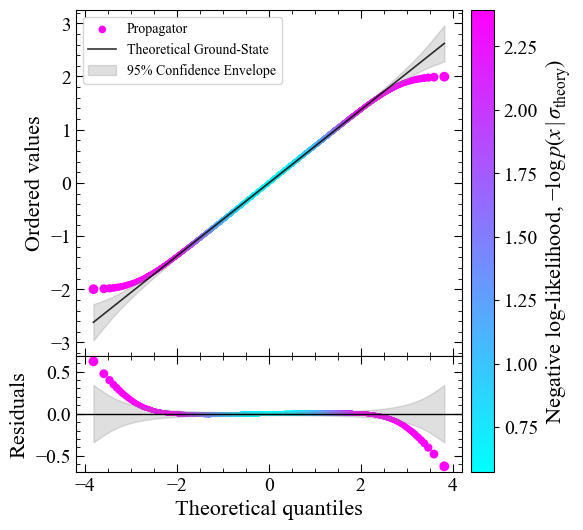

In [25]:
# --- Figure layout ---
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)

ax_qq = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax_qq)

# -------------------
# Top: QQ plot
# -------------------
sc = ax_qq.scatter( #Data
    osm, osr,
    c=nll,
    norm=norm,
    cmap=cmap_color,
    s=sizes,
    edgecolors='none',
    label = "Propagator"
)

ax_qq.plot( #Black Normal Line
    osm,
    slope * osm + intercept,
    color='black',
    lw=1.2,
    alpha=0.8,
    label = "Theoretical Ground-State"
)


ax_qq.fill_between(osm, lower, upper, color='grey', alpha=0.25, label = "95% Confidence Envelope")

ax_qq.set_ylabel("Ordered values")
ax_qq.minorticks_on()
ax_qq.tick_params(which='major', length=6, direction='in', top=True, right=True)
ax_qq.tick_params(which='minor', length=3, direction='in', top=True, right=True)

plt.setp(ax_qq.get_xticklabels(), visible=False)
ax_qq.legend(loc='upper left')

# -------------------
# Bottom: detrended QQ
# -------------------
ax_res.scatter(
    osm, qq_res,
    c=nll,
    norm=norm,
    cmap=cmap_color,
    s=sizes,
    edgecolors='none'
)

# ±2σ band
ax_res.axhline(0, color='black', lw=1)

ax_res.set_xlabel("Theoretical quantiles")
ax_res.set_ylabel(r"Residuals")

ax_res.minorticks_on()
ax_res.tick_params(which='major', length=6, direction='in', top=True, right=True)
ax_res.tick_params(which='minor', length=3, direction='in', top=True, right=True)

res_upper = z_alpha * slope * sigma_q
res_lower = -z_alpha * slope * sigma_q

ax_res.fill_between(
    osm,
    res_lower,
    res_upper,
    color='grey',
    alpha=0.25
)

# -------------------
# Colorbar (|z|)
# -------------------
cbar = fig.colorbar(sc, ax=[ax_qq, ax_res], pad=0.02)
cbar.set_label(
    r"Negative log-likelihood, $-\log p(x\,|\,\sigma_{\mathrm{theory}})$"
)

plt.savefig(pc_savepath_qq_prop, bbox_inches='tight')
plt.show()

# HT for Propagator

In [18]:
# Known theoretical distribution
mu = 0.0
sigma = 1 / np.sqrt(2)

# Normalise weights (important!)
weights = weights_prop / np.sum(weights_prop)

# Experiment parameters
N_subsample = 10_000
N_repeats = 100

ks_stats = np.empty(N_repeats)
ks_pvals = np.empty(N_repeats)

ad_stats = np.empty(N_repeats)

for i in range(N_repeats):

    # Weighted resampling
    sample = np.random.choice(
        x_end_prop,
        size=N_subsample,
        replace=True,
        p=weights
    )

    # --------------------
    # Fixed-parameter transform
    # --------------------
    z = (sample - mu) / sigma

    # --------------------
    # Kolmogorov–Smirnov
    # --------------------
    ks_res = stats.kstest(
        z,
        'norm',
        method='asymp'
    )

    ks_stats[i] = ks_res.statistic
    ks_pvals[i] = ks_res.pvalue

    # --------------------
    # Anderson–Darling (fixed params)
    # --------------------
    ad_res = stats.anderson(z, dist='norm')
    ad_stats[i] = ad_res.statistic

print("KS statistic:")
print(f"  mean = {ks_stats.mean():.4e}")
print(f"  std  = {ks_stats.std():.4e}")

print("\nKS p-values:")
print(f"  median = {np.median(ks_pvals):.3f}")
print(f"  fraction p < 0.05 = {np.mean(ks_pvals < 0.05):.2f}")

print("\nAD statistic:")
print(f"  mean = {ad_stats.mean():.4f}")
print(f"  std  = {ad_stats.std():.4f}")


KS statistic:
  mean = 1.4275e-02
  std  = 2.9861e-03

KS p-values:
  median = 0.059
  fraction p < 0.05 = 0.49

AD statistic:
  mean = 1.1614
  std  = 0.2747


# Q-Q For Metrop